In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import widgets
from IPython.display import display

%matplotlib notebook

In [3]:
posts = pd.read_sql_table('post', 'sqlite:///db.sqlite')
likes = pd.read_sql_table('like', 'sqlite:///db.sqlite')
reposts = pd.read_sql_table('repost', 'sqlite:///db.sqlite')
follows = pd.read_sql_table('follow', 'sqlite:///db.sqlite')


In [4]:
tabs = []
for tab in (posts, likes, reposts, follows):
    widg = widgets.Output()
    with widg:
        display(tab)
    tabs.append(widg)
        
tab = widgets.Tab(children=tabs, titles = ['posts', 'likes', 'reposts', 'follows'])
tab

Basic Summaries


In [5]:
posts['indexedAt'] = pd.to_datetime(posts['indexedAt'])
span = posts['indexedAt'].max() - posts['indexedAt'].min()
posting_accounts = set(posts['authorDid'])
liking_accounts = set(likes['authorDid'])
posters_only = posting_accounts - liking_accounts
likers_only = liking_accounts - posting_accounts
posts_and_likes = posting_accounts.intersection(liking_accounts)

print(f"""
Timespan: {span}
Posting Accounts: {len(posting_accounts)}
Liking Accounts: {len(liking_accounts)}
Accounts that only posted: {len(posters_only)}
Accounts that only liked: {len(likers_only)}
Accounts that posted and liked: {len(posts_and_likes)}
""")


Timespan: 1 days 00:29:00.608000
Posting Accounts: 134910
Liking Accounts: 201814
Accounts that only posted: 43655
Accounts that only liked: 110559
Accounts that posted and liked: 91255



# Interaction Distributions

Likes per post

In [6]:
post_likes = likes.groupby('subjectCid'
    ).agg(likes=('uri', 'count')
    ).reset_index(
    ).rename(columns={'subjectCid':'cid'})
post_likes

cid  likes
0       bafyreia222dxd77nwlefofspvv4zyo4vcyidfm53vxhzl...     28
1       bafyreia222hs2ffawpplfo3nfs2g4ibqleg7exybmxx4m...      1
2       bafyreia222p4uouja7nmodbin7msvfyky65zd4epn4fqq...      5
3       bafyreia222tx72zwcfs5mzdtssw4xcpwvmzsan6lk4yrh...      1
4       bafyreia223lumxspphn5wcbw2v65aeon3l2t3frtgrik5...      3
...                                                   ...    ...
637533  bafyreihzzyn6h4roumu7cebt2ywblpxryz42tt4yd66vb...      1
637534  bafyreihzzyzsfj2qo4lonn3ny6kht6xy4squzfmha4luf...      1
637535  bafyreihzzzd6jvfod4gmeucp4wgtn2fzxw6lggztkmeum...      2
637536  bafyreihzzzfwyi7hxm5wusper7hn6qbi2bx6gibiz4skm...     95
637537  bafyreihzzzgh23q2dplc32rqfuuqn6seimmujmtrq66dc...     19

[637538 rows x 2 columns]

In [7]:
posts = posts.merge(post_likes, left_on='cid', right_on='cid', how='left')
posts.loc[posts['likes'].isna(), 'likes'] = 0

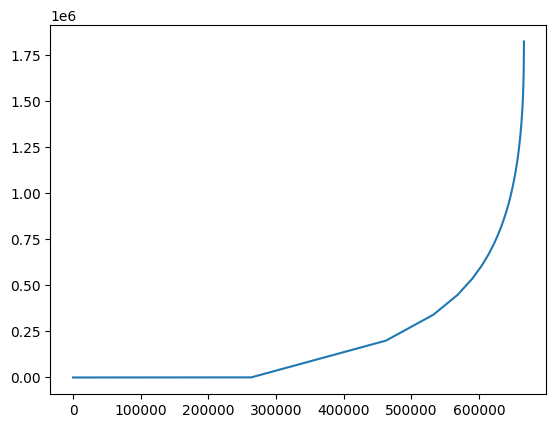

In [11]:
%matplotlib inline
y = posts.sort_values(by='likes')['likes'].cumsum()
plt.plot(y.reset_index(drop=True))
plt.title('Cumulative sum of likes by post')
plt.show()

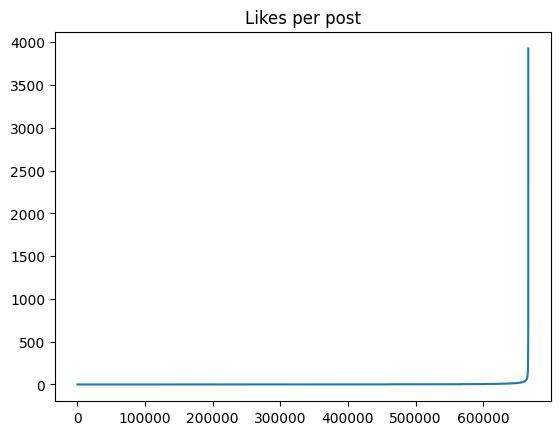

In [51]:
%matplotlib inline
y = posts.sort_values(by='likes')['likes']
plt.plot(y.reset_index(drop=True))
plt.title('Likes per post')
plt.show()

In [12]:
np.sum(posts['likes'] == 0) / posts.shape[0]

0.3944738883046787

In [13]:
np.sum(posts['likes'] <= 1) / posts.shape[0]

0.6932166446400256

Likes per account

In [14]:
accounts = pd.concat([likes['subjectDid'], likes['authorDid'], posts['authorDid']])

accounts = pd.DataFrame({'account': accounts.unique()})

accounts

account
0       did:plc:lhfbzpkdw2jk5i6im5pd2mi5
1       did:plc:btaxnpi4resvm2uz4n7tcp3f
2       did:plc:ky3xc27d4ct6ntwxsu7tjpx7
3       did:plc:z3ds6onyuoyfnx42qgoddhbp
4       did:plc:hqzxqh634sd546rfoazslb5h
...                                  ...
269812  did:plc:p6t6ari5h7bcim3iq3zs3fwr
269813  did:plc:omiligdebd4dwcthsxvn2fgi
269814  did:plc:fg6wnip4zgzz3277lz7djpet
269815  did:plc:5czjjn5zjvkxec6rcvvuidgq
269816  did:plc:jdiqko5hqd3chtepm4docjsc

[269817 rows x 1 columns]

In [15]:
account_likes = likes.groupby('subjectDid'
    ).agg(likes=('uri', 'count')
    ).reset_index(
    ).rename(columns={'subjectDid':'account'})
account_likes

account  likes
0       did:plc:2224x6c53tqc6dpnbamce2yg     64
1       did:plc:222ombk5yfjty5jw6r6566tk      4
2       did:plc:222p42fegwhwfyrc3gqam76j    119
3       did:plc:222qqedb2kgz3ulwbpboltw2      6
4       did:plc:222rnvnta2lbl364bog2plxw    575
...                                  ...    ...
133639  did:plc:zzz2awwhi7smhg3qn6th37xg      2
133640  did:plc:zzza7zo2lho4etts27epjgpc      1
133641  did:plc:zzzj2bhzojle3nic4wpwmcsm      1
133642  did:plc:zzznrmktdln6qlvsqigd6ubc      7
133643  did:plc:zzzzet3m2cnkmtsjyusz7uzs     67

[133644 rows x 2 columns]

In [16]:
accounts = accounts.merge(account_likes, left_on='account', right_on='account', how='left')
accounts.loc[accounts['likes'].isna(), 'likes'] = 0

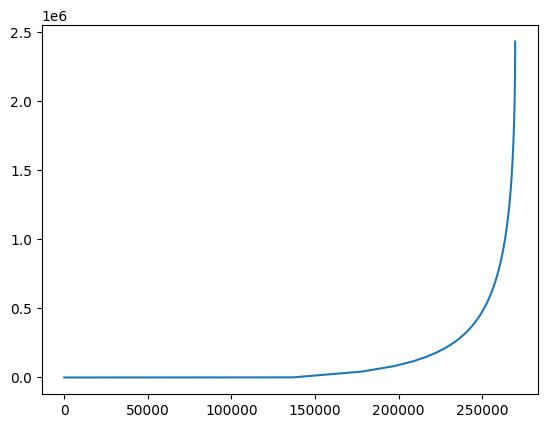

In [17]:
%matplotlib inline
y_accounts = accounts.sort_values(by='likes')['likes'].cumsum().reset_index(drop=True)
plt.plot(y_accounts)
plt.show()

In [18]:
quants = [0, 0.25, 0.5, 0.75, 0.9, .95, .99]
quantiles = accounts['likes'].quantile(quants)
quantiles

0.00      0.0
0.25      0.0
0.50      0.0
0.75      3.0
0.90     13.0
0.95     33.0
0.99    152.0
Name: likes, dtype: float64

In [19]:
sorted_accounts = accounts.sort_values(by='likes')
quant_idx = [np.where(sorted_accounts['likes'] >= q)[0][0] for q in quantiles]
quant_idx

[0, 0, 0, 196497, 241490, 256295, 267113]

In [20]:
np.where(sorted_accounts['likes'] > 0)

(array([136173, 136174, 136175, ..., 269814, 269815, 269816]),)

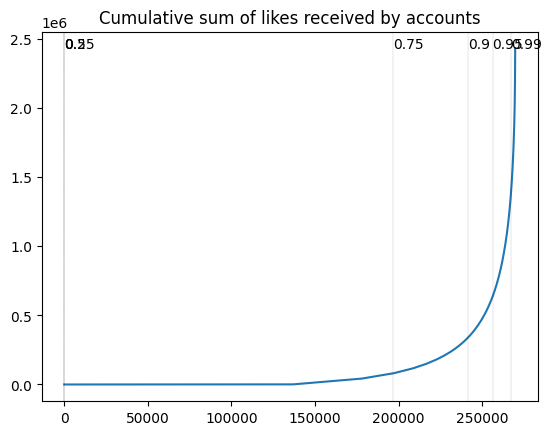

In [22]:
%matplotlib inline

cumsum_accounts = sorted_accounts['likes'].cumsum().reset_index(drop=True)

plt.plot(cumsum_accounts)

for q_label, q_idx in zip(quants, quant_idx):
    plt.axvline(x=q_idx, color='black', linestyle='--', linewidth=.1)
    plt.annotate(text=str(q_label), xy=(q_idx, max(cumsum_accounts)), xycoords='data')

plt.title('Cumulative sum of likes received by accounts')    

plt.show()

In [23]:
len(accounts[accounts['likes']==0]['likes']) / len(accounts)

0.5046865097454941

Proportion of interactions received by the 99th and 95th percentile of most interacted with accounts

In [24]:
percentile = 0.99
accounts.loc[accounts['likes'] >= quantiles[percentile], 'likes'].sum() / accounts['likes'].sum()

0.442995115042035

In [25]:
percentile = 0.95
accounts.loc[accounts['likes'] >= quantiles[percentile], 'likes'].sum() / accounts['likes'].sum()

0.73839113058112

Excluding interactions with the top (percentile) accounts

In [26]:
top_accounts = accounts.loc[accounts['likes'] >= quantiles[percentile]]


In [27]:
top_posts = posts.loc[posts['authorDid'].isin(top_accounts['account'])]
non_top_posts = posts.loc[~posts['authorDid'].isin(top_accounts['account'])]
top_threads = posts.loc[np.logical_or(
    posts['replyRoot'].isin(top_posts['uri']),
    posts['replyParent'].isin(top_posts['uri'])
)]

In [28]:
non_top_reply_likes = likes.loc[
    np.logical_and(
        ~likes['subjectUri'].isin(top_threads['uri']),
        ~likes['subjectDid'].isin(top_accounts['account'])
    )]
non_top_account_likes = likes.loc[
    ~likes['subjectDid'].isin(top_accounts['account'])
]

non_top_reply_likes

uri  \
1        at://did:plc:iomleec6ojlmywkrwqjbr57o/app.bsky...   
2        at://did:plc:cakburidjcwro44hweyxazjg/app.bsky...   
6        at://did:plc:kwmi7ftr3g7hbohzauip3mxn/app.bsky...   
10       at://did:plc:43eonpufv7sg6hglanhbhraw/app.bsky...   
11       at://did:plc:ipepj5vzwwzvggali4tnccwj/app.bsky...   
...                                                    ...   
2431516  at://did:plc:feaa5k4utn2gayj2bxsvx3cx/app.bsky...   
2431523  at://did:plc:7yeirudvbp5l3lmp4ycgbml5/app.bsky...   
2431524  at://did:plc:qdriunexx3nobe5kpltycouy/app.bsky...   
2431529  at://did:plc:ycdfsvtnosafdvko26fc7i43/app.bsky...   
2431538  at://did:plc:ct5u4vpg5ajhx6wxihtca6qh/app.bsky...   

                                                       cid  \
1        bafyreidgvotn7srwum67gsv5rkjbiybtwjwpei5tvnrws...   
2        bafyreiawjvozspsyg5yelmmnb3hs4sp7vsjqddpr6t636...   
6        bafyreiasf7jxlprpiix6eo4x7ifb7zeaduu2kcftyxpyi...   
10       bafyreieyyoeepsexamgybk5dun3sqxwiqftas2ent47np...   
11       bafyreiht7xdi2cuc6bwoer4qcf5nwzekyt7kvwq6cv4la...   
...                                                    ...   
2431516  bafyreifm7bfz6t22liztgjjtnrm3svwiuyno37chgh4ki...   
2431523  bafyreigj5r4j2cmgyops6naxbnk6qsdk7woqtjwy75fh4...   
2431524  bafyreifncwwa4desh5ju6re2ykvfgchnppxvzlk5spili...   
2431529  bafyreigvptivi6zu6njihe7wfuii6rdhj5y3l6u2azihw...   
2431538  bafyreiduxg3lwaaibwaxsrsck44rzfpefliil2otfy67z...   

                                authorDid                 indexedAt  \
1        did:plc:iomleec6ojlmywkrwqjbr57o  2023-12-27T03:12:43.896Z   
2        did:plc:cakburidjcwro44hweyxazjg  2023-12-27T03:12:43.968Z   
6        did:plc:kwmi7ftr3g7hbohzauip3mxn  2023-12-27T03:12:44.068Z   
10       did:plc:43eonpufv7sg6hglanhbhraw  2023-12-27T03:12:44.287Z   
11       did:plc:ipepj5vzwwzvggali4tnccwj  2023-12-27T03:12:44.369Z   
...                                   ...                       ...   
2431516  did:plc:feaa5k4utn2gayj2bxsvx3cx  2023-12-28T03:41:47.605Z   
2431523  did:plc:7yeirudvbp5l3lmp4ycgbml5  2023-12-28T03:41:47.666Z   
2431524  did:plc:qdriunexx3nobe5kpltycouy  2023-12-28T03:41:47.686Z   
2431529  did:plc:ycdfsvtnosafdvko26fc7i43  2023-12-28T03:41:47.745Z   
2431538  did:plc:ct5u4vpg5ajhx6wxihtca6qh  2023-12-28T03:41:48.066Z   

                        createdAt  \
1        2023-12-27T03:12:42.248Z   
2        2023-12-27T03:12:43.705Z   
6        2023-12-27T03:12:45.463Z   
10       2023-12-27T03:12:44.003Z   
11       2023-12-27T03:12:43.406Z   
...                           ...   
2431516  2023-12-28T03:41:46.687Z   
2431523  2023-12-28T03:41:46.741Z   
2431524  2023-12-28T03:41:46.886Z   
2431529  2023-12-28T03:41:46.679Z   
2431538  2023-12-28T03:41:47.744Z   

                                                subjectUri  \
1        at://did:plc:btaxnpi4resvm2uz4n7tcp3f/app.bsky...   
2        at://did:plc:ky3xc27d4ct6ntwxsu7tjpx7/app.bsky...   
6        at://did:plc:wxj3cnbus6js5f7hjwowoxoq/app.bsky...   
10       at://did:plc:mgsxkvihm65lecdzbavku3tk/app.bsky...   
11       at://did:plc:e4r2dxzbadqabu63wne4tosx/app.bsky...   
...                                                    ...   
2431516  at://did:plc:q4b6fmgkkrybhf5ejbrgcmgn/app.bsky...   
2431523  at://did:plc:fllmcdrrhebd55j4mp43igmb/app.bsky...   
2431524  at://did:plc:i3l64jceufl7zcbk3r2sfiyc/app.bsky...   
2431529  at://did:plc:gxxkzpo2cw6q2ynee64rxppw/app.bsky...   
2431538  at://did:plc:4msurte3uoa37puu2ma673t6/app.bsky...   

                                                subjectCid  \
1        bafyreifsu35qmmr66fooemrvkke6rdd3qq5mdjvtsqs5y...   
2        bafyreib7r6526nciyilv3ky345zbmbh4w3tsarc74z72c...   
6        bafyreifcftx7xktszbhmylitz34hf66ivmboymshgtchl...   
10       bafyreibyyeobzn34r4edmeiaarancnpjbuesdiuqxkxfy...   
11       bafyreibk6afarwpw7rdzifkxbi5kgy36tolpe45lxvjzq...   
...                                                    ...   
2431516  bafyreibl7b6qni2jxir2v4uf5wfcurx3bbsgprvodwb2s...   
2431523  bafyreiatd54b5pcp

Proportion of posts from top posters

In [29]:
top_posts.shape[0] / posts.shape[0]

0.4083754239690857

Proportion of non-top account likes that are not in threads with top accounts

In [30]:
non_top_reply_likes.shape[0] / non_top_account_likes.shape[0]

0.8589246581587577

Proportion of likes to non-top accounts

In [31]:
non_top_account_likes.shape[0] / likes.shape[0]

0.26160886941888

Proportion of likes to non-top accounts that are not in threads with top accounts

In [32]:
non_top_reply_likes.shape[0] / likes.shape[0]

0.22470230873691058

Number of top accounts

In [33]:
top_accounts.shape[0]

13522

Quantiles of likes received by non-top posts

In [34]:
non_top_posts['likes'].quantile(quants)

0.00     0.0
0.25     0.0
0.50     0.0
0.75     1.0
0.90     3.0
0.95     5.0
0.99    11.0
Name: likes, dtype: float64

In [35]:
sum(non_top_posts['likes'] <= 1) / non_top_posts.shape[0]

0.8008732539358548

In [36]:
non_top_posts['likes'].max()

32.0

In [37]:
top_posts['likes'].max()

3928.0

How many accounts who posted received any likes?

In [38]:
posting_account_likes = posts.groupby('authorDid'
    ).agg(
      likes=('likes', 'sum'),
      posts=('uri', 'count')
    ).reset_index()

In [39]:
sum(posting_account_likes['likes'] == 0) / posting_account_likes.shape[0]

0.31761174116077384

In [40]:
posting_account_likes['likes_per_post'] = \
    posting_account_likes['likes'] / posting_account_likes['posts']

In [41]:
lpp_quantiles = posting_account_likes['likes_per_post'].quantile(quants)
lpp_quantiles

0.00     0.0
0.25     0.0
0.50     1.0
0.75     2.0
0.90     5.0
0.95     8.3
0.99    28.0
Name: likes_per_post, dtype: float64

In [42]:
nontop_lpp_quantiles = posting_account_likes[
    ~posting_account_likes['authorDid'].isin(top_accounts['account'])
]['likes_per_post'].quantile(quants)
nontop_lpp_quantiles

0.00     0.000000
0.25     0.000000
0.50     0.833333
0.75     1.625000
0.90     3.250000
0.95     5.000000
0.99    12.000000
Name: likes_per_post, dtype: float64

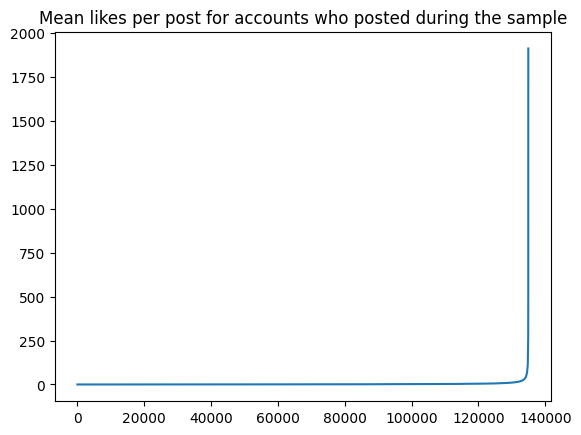

In [50]:
%matplotlib inline
lpp_sorted = posting_account_likes.sort_values('likes_per_post').reset_index()
plt.plot(lpp_sorted['likes_per_post'])
plt.title('Mean likes per post for accounts who posted during the sample')
plt.show()

In [44]:
non_posting_accounts = accounts[~accounts['account'].isin(posting_accounts)]
non_posting_accounts

account  likes
1       did:plc:btaxnpi4resvm2uz4n7tcp3f    2.0
6       did:plc:wxj3cnbus6js5f7hjwowoxoq    2.0
9       did:plc:acmcckkebktixw6lzhx76fsq   61.0
10      did:plc:mgsxkvihm65lecdzbavku3tk    7.0
11      did:plc:e4r2dxzbadqabu63wne4tosx    3.0
...                                  ...    ...
247965  did:plc:zeau3uhk2sm4bdpeg7cl2hk7    0.0
247966  did:plc:fl4mmwjixqnonmwfxti6tbb7    0.0
247967  did:plc:ylz7ikmlz7kn33s6xfn2hfbr    0.0
247968  did:plc:6dqstbx266mlgjvdmr4u4vbw    0.0
247969  did:plc:qrpae44n3nmwjvm4le6foryx    0.0

[134907 rows x 2 columns]

In [45]:
non_posting_accounts.shape[0] / accounts.shape[0]

0.4999944406764585

In [46]:
accounts.shape[0]

269817

In [47]:
sum(non_posting_accounts['likes'] > 0) / non_posting_accounts.shape[0]

0.2707272417294877

In [48]:
non_posting_accounts['likes'].sum() / accounts['likes'].sum()

0.06262517756192973

In [49]:
top_accounts

account  likes
0       did:plc:lhfbzpkdw2jk5i6im5pd2mi5  160.0
3       did:plc:z3ds6onyuoyfnx42qgoddhbp  313.0
4       did:plc:hqzxqh634sd546rfoazslb5h  103.0
5       did:plc:ats4shmeia7i7ildqm3denmd  405.0
7       did:plc:7o55wjsyg2ylsmlr5to6gb67  313.0
...                                  ...    ...
130508  did:plc:d5torywdns2h4kghsqmil7k6   46.0
130569  did:plc:2tdfuxjpemewkkyhi2db7lck   46.0
130642  did:plc:en7khbuwadt72huhdyrvhf7s   33.0
131261  did:plc:oafrik4tx7nkmqysa4kpnuv5  243.0
132789  did:plc:osxrt2mj6274mw4de6duncpu   39.0

[13522 rows x 2 columns]

In [135]:
accounts

account   likes
0      did:plc:nvog7rczakwzh5ckxnjnwqdd  2009.0
1      did:plc:z3eu4ec7csnznxrrdrabudgj   331.0
2      did:plc:m2hze6zxa744iberzknpkc3i    12.0
3      did:plc:ykzmsemoxmlzmrci2p77eqkm    41.0
4      did:plc:afrooick4a2hy2m2eme5ognc   103.0
...                                 ...     ...
45665  did:plc:efkxngznfeo2onvrjhskmmou     0.0
45666  did:plc:pv4x356soulpp7spindi57gz     0.0
45667  did:plc:w5reveglbupc6sz4txst2v7b     0.0
45668  did:plc:7o6uylwbtcpwk5c5pqa67fsl     0.0
45669  did:plc:uppr7hyd3a2zzss54drq2s5j     0.0

[45670 rows x 2 columns]